# Project: Image Classification (CIFAR-10 dataset)
- Date: July 12 - July 15 2025

- Description :
    This project aims to build a model able to predict the nature or the class of an object on an image according what it will learned. We will use here CIFAR-10 dataset and mostly convolution network (CNN). 

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#Function for normalization
transform = transforms.Compose([
    transforms.ToTensor(),  #=> [0,1]
    transforms.Normalize(mean=(0.5,)*3, std=(0.5,)*3) #=> [-1,1] 
    ])
#The difference between this function and the default transform function (transforms.ToTensor())
# is there is no normalization in the second one.

# Download of the data
trainset = datasets.CIFAR10(root='./data', train=True, download=True,  transform=transform )
testset = datasets.CIFAR10(root='./data', train=False, download=True,  transform=transform)

# Splitting of the data
n_total = trainset.data.shape[0] # 50 000
n_train = int(0.8*n_total) #80% for training (40 000) 
n_val = n_total-n_train #20% for validation (10 000)
test_ds = testset # 10 000

train_ds, val_ds=random_split(trainset, [n_train,n_val],generator=torch.Generator().manual_seed(42))

#Creating of dataloads
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2)
test_loader  = torch.utils.data.DataLoader(testset,  batch_size=64, shuffle=False, num_workers=2)

# Classes
classes = trainset.classes

In [3]:
#Just for looking  
print("Train set:\n",trainset, trainset.data.shape)
print(trainset.data)
print("---------------")
print(train_loader)
print(train_loader.dataset)
print("---------------")
print("Test set:\n",testset, testset.data.shape)
print(testset)
print("---------------")
print("Classes:\n",classes)
print(trainset[0])

Train set:
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           ) (50000, 32, 32, 3)
[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   

# Display of some images of the data

Learn how to display an image


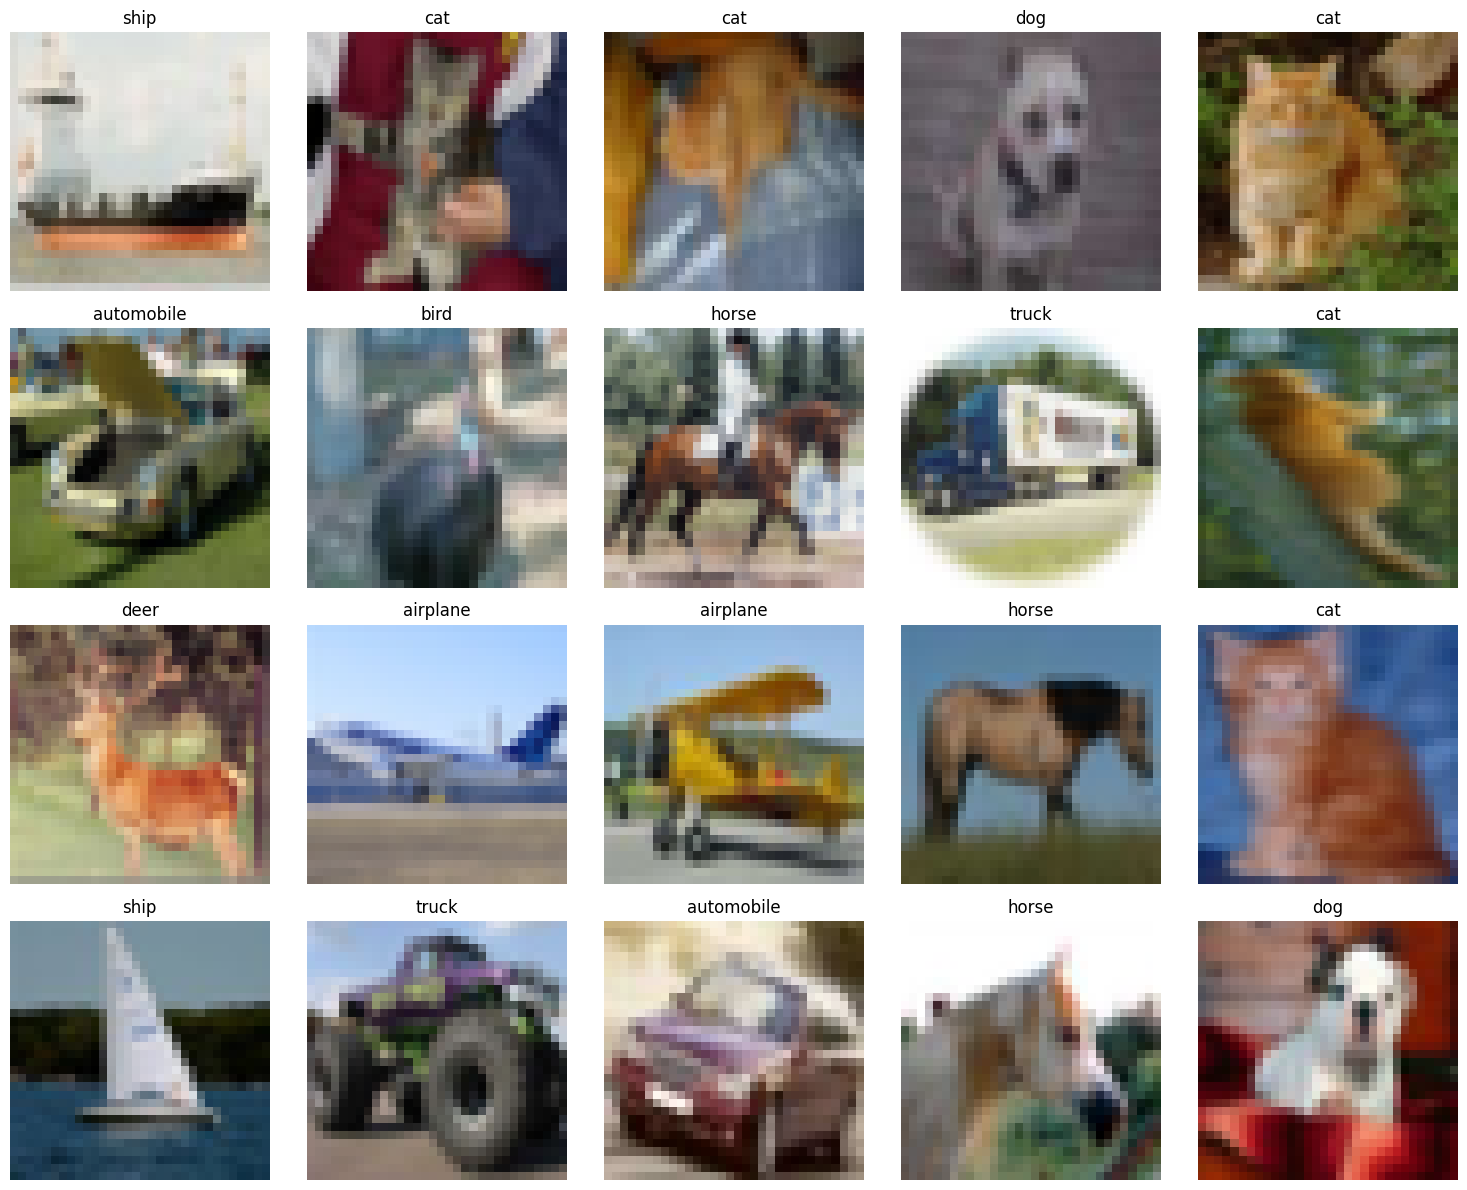

In [4]:
## Made by chatgpt:

# 1. Préparation du DataLoader
displayloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True)

# 2. Récupère un batch
images, labels = next(iter(displayloader))
# images.shape = (20, 3, 32, 32)

# 3. Dénormalise pour affichage
mean = torch.tensor([0.5,0.5,0.5])[:, None, None]
std  = torch.tensor([0.5,0.5,0.5])[:, None, None]
images_disp = images * std + mean  # valeurs entre 0 et 1

# 4. Prépare la grille de subplots
n = images_disp.size(0)        # ici 20
cols = 5
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

# 5. Affiche chaque image avec son label
classes = trainset.classes     # ["airplane", "automobile", …, "truck"]
for i in range(n):
    ax = axes[i]
    img = images_disp[i].permute(1,2,0).numpy()  # [H,W,C]
    ax.imshow(img, interpolation='nearest')
    ax.set_title(classes[labels[i]])
    ax.axis('off')

# 6. Masque les subplots vides (si n < rows*cols)
for j in range(n, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Building of Models


In [5]:
#We build first a very simple model to understant how it's work.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolution bloc
        self.conv=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1), # 32x32x3 => 30x30x16
            nn.ReLU(),
            nn.MaxPool2d(2) # 30x30x16 => 15x15x16
        )
        #Fully Connected bloc
        self.fc=nn.Sequential(
            nn.Flatten(),
            nn.Linear(15*15*16,10) # 10 neurons
        )
    
    def forward(self,X):
        X=self.conv(X)
        return self.fc(X)
    
#A more complex model
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolution bloc with 2 convolutions
        self.conv=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1), # 32x32x3 => 30x30x16
            nn.ReLU(),
            nn.MaxPool2d(2), # 30x30x16 => 15x15x16
            nn.Conv2d(16,32,kernel_size=2,stride=1), # 15x15x16 => 14x14x32
            nn.ReLU(),
            nn.MaxPool2d(2) # 14x14x32 => 7x7x32
        )
        #Full Connected bloc with 2 layers
        self.fc=nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*32,250), # 250 classes
            nn.ReLU(), #for the non-linearity between the layer
            nn.Linear(250,10) # 10 classes
        )
    
    def forward(self,X):
        X=self.conv(X)
        return self.fc(X)

# Same like CNN1 but with dropout
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolution bloc with 2 convolutions
        self.conv=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1), # 32x32x3 => 30x30x16
            nn.ReLU(),
            nn.MaxPool2d(2), # 30x30x16 => 15x15x16
            nn.Conv2d(16,32,kernel_size=2,stride=1), # 15x15x16 => 14x14x32
            nn.ReLU(),
            nn.MaxPool2d(2) # 14x14x32 => 7x7x32
        )
        #Full Connected bloc with 2 layers
        self.fc=nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*32,250), # 250 classes
            nn.ReLU(), #for the non-linearity between the layer
            nn.Dropout(p=0.5),
            nn.Linear(250,10) # 10 classes
        )
    
    def forward(self,X):
        X=self.conv(X)
        return self.fc(X)

Note a moi-même: Regarder maintenant comment je voudrais que mes modeles apprenent ( CrossEntropyLoss ou backpropagattion...)

In [6]:
# use it after maybe : device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #if we run on CPU or GPU suitable with cuba

#Initailization of the models
model_simpleCNN = SimpleCNN()
model_cnn1      = CNN1()
model_cnn2      = CNN2()

# loss criterion (critère de perte ou fonction de perte)
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer_simpleCNN = optim.Adam(model_simpleCNN.parameters(), lr=1e-3)
optimizer_cnn1      = optim.Adam(model_cnn1.parameters(), lr=1e-3)
optimizer_cnn2      = optim.Adam(model_cnn2.parameters(), lr=1e-3)


# Training and Evaluation:

We'll do it for each model

In [ ]:
# we must avoid to run this function twice for the same model because training and evaluation will continue and not restart
def train_and_eval(model,optimizer, num_epochs=10):
    best_acc = 0.0
    #best_loss=float('inf')
    for epoch in range(num_epochs):
        
        #Training
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad() # Set all gradients to zero
            logits = model(images) # logits computed by the model
            loss   = criterion(logits, labels) 
            loss.backward() # compute of gradiants
            optimizer.step() # Update parameters

        #Evaluation
        model.eval()
        val_loss = 0.0
        correct  = 0
        with torch.no_grad():
            for images, labels in val_loader:
                predictions = model(images)
                val_loss += criterion(predictions, labels).item() * images.size(0) # loss in the batch = accuracy of loss in the batch * number of images in the batch
                preds     = predictions.argmax(dim=1) # predictions: we take the highest score in the logits 
                correct  += (preds == labels).sum().item() # number of good predictions

        val_loss /= n_val
        val_acc   = correct / n_val
        print(f"Époque {epoch+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.2%}")

        # Best model: Here we save two kind of best models but generally only the first one is used.
        #a- regarding the accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"./best_models/best_{model.__class__}_by_acc.pth")
        # b- regarding the loss function
        #if val_loss < best_loss: 
        #    best_loss = val_loss
        #    torch.save(model.state_dict(), f"./best_models/best_{model.__class__}_by_loss.pth")
    state = torch.load(f"./best_models/best_{model.__class__}_by_acc.pth",map_location="cpu")
    model.load_state_dict(state)
    return model


In [8]:
print("======Simple CNN=====")
model_simpleCNN=train_and_eval(model_simpleCNN, optimizer_simpleCNN)

======Simple CNN=====
Époque 1 — val_loss: 1.2786, val_acc: 55.45%
Époque 2 — val_loss: 1.1974, val_acc: 57.99%
Époque 3 — val_loss: 1.1464, val_acc: 60.32%
Époque 4 — val_loss: 1.1371, val_acc: 60.42%
Époque 5 — val_loss: 1.1393, val_acc: 60.82%
Époque 6 — val_loss: 1.1208, val_acc: 61.70%
Époque 7 — val_loss: 1.1123, val_acc: 61.82%
Époque 8 — val_loss: 1.1123, val_acc: 61.58%
Époque 9 — val_loss: 1.1073, val_acc: 62.20%
Époque 10 — val_loss: 1.1016, val_acc: 62.60%


In [9]:
print("=====CNN 1====")
model_cnn1=train_and_eval(model_cnn1, optimizer_cnn1)

=====CNN 1====
Époque 1 — val_loss: 1.2654, val_acc: 55.05%
Époque 2 — val_loss: 1.1357, val_acc: 59.80%
Époque 3 — val_loss: 1.0461, val_acc: 63.07%
Époque 4 — val_loss: 0.9907, val_acc: 65.04%
Époque 5 — val_loss: 0.9651, val_acc: 66.21%
Époque 6 — val_loss: 0.9685, val_acc: 66.38%
Époque 7 — val_loss: 0.9383, val_acc: 67.33%
Époque 8 — val_loss: 0.9438, val_acc: 68.42%
Époque 9 — val_loss: 1.0217, val_acc: 67.85%
Époque 10 — val_loss: 1.0342, val_acc: 67.53%


In [10]:
print("======CNN 2======")
model_cnn2=train_and_eval(model_cnn2, optimizer_cnn2)

======CNN 2======
Époque 1 — val_loss: 1.3240, val_acc: 52.15%
Époque 2 — val_loss: 1.1740, val_acc: 58.07%
Époque 3 — val_loss: 1.0787, val_acc: 61.91%
Époque 4 — val_loss: 1.0058, val_acc: 65.16%
Époque 5 — val_loss: 0.9445, val_acc: 66.76%
Époque 6 — val_loss: 0.9265, val_acc: 67.30%
Époque 7 — val_loss: 0.8914, val_acc: 68.71%
Époque 8 — val_loss: 0.8971, val_acc: 68.89%
Époque 9 — val_loss: 0.8693, val_acc: 69.70%
Époque 10 — val_loss: 0.8787, val_acc: 69.33%


# Tests

Now we test the models on the test_loader

In [11]:
def test_model(name,model):
        val_loss = 0.0
        correct  = 0
        with torch.no_grad():
            for images, labels in test_loader:
                predictions = model(images)
                val_loss += criterion(predictions, labels).item() * images.size(0) # loss in the batch = loss accuracy in the batch * number of image in the batch
                preds     = predictions.argmax(dim=1) # predictions: we take the highest score in the logits 
                correct  += (preds == labels).sum().item() # number of good predictions

        val_loss /= n_val
        val_acc   = correct / n_val
        print(f"{name}: val_loss: {val_loss:.4f}, val_acc: {val_acc:.2%}")

In [12]:
test_model("Simple CNN", model_simpleCNN)
test_model("CNN1", model_cnn1)
test_model("CNN2", model_cnn2)

Simple CNN: val_loss: 1.1059, val_acc: 61.90%
CNN1: val_loss: 0.9617, val_acc: 68.21%
CNN2: val_loss: 0.8757, val_acc: 69.17%


Now we will test on real images find on google.

In [ ]:
# Did by chatgpt but understood:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

test_dataset = datasets.ImageFolder(
    root='./image_google',               # racine
    transform=transform
)
# — image_google attend un sous‑dossier pour chaque “classe” ; 
#   ici on laisse un seul sous‑dossier “image”

# DataLoader pour parcourir en batch
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4) Inférence
model_cnn2.eval()
all_preds = []
with torch.no_grad():
    for images, _ in test_loader:    # les labels sont fictifs ici
        logits = model_simpleCNN(images)
        preds  = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())

# 5) Afficher les résultats
for path, pred in zip(test_dataset.imgs, all_preds):
    img_path = path[0]
    print(f"{img_path:30s} → classe prédite : {classes[pred]}")

./image_google/image/bird.jpeg → classe prédite : bird
./image_google/image/cat.jpeg  → classe prédite : bird
./image_google/image/deer.jpeg → classe prédite : deer
./image_google/image/dog.jpeg  → classe prédite : deer
./image_google/image/frog.jpeg → classe prédite : bird
./image_google/image/plane.jpg → classe prédite : airplane
./image_google/image/ship.jpeg → classe prédite : ship
./image_google/image/truck.jpeg → classe prédite : truck


# Conclusion

This project is the first on deep learning and was base on image classification. I have learned many things, usefull functions, the way to proceed to create, train, evaluate and test a model.
However we build models, those build are not good enough because the best accuracy is less than 80%. I have to find how to build better models ( maybe with more convolution layers).